In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from read_HiC import name_chromosomes
from read_HiC import MiddlePointLoci
from read_HiC import Map_Topology_to_Structure
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

import sys
path=r'C:\Users\scalvinib\Documents\Phd_project_reduced\work directory jupyter lab'\
     r'\topology\genome_topology\functions'
sys.path.append(path)

from plotting_tools import set_layout
from plotting_tools import save_figures
from genome_topology import normalize_psc
from genome_topology import get_matrix
from genome_topology import normalize_psc
from statistical_analysis import correlate
from matrix_analysis import Select_entangled_fraction

In [9]:
#Create plot above heatmap
def plot_over_map(data,avg, ax, ax_histx, stats):
    data=data.transpose()
    label = 'Corr = {}\np = {}'.format(stats[0], stats[1])
    ax_histx.tick_params(axis="x", labelbottom=False)
    cmap = sns.color_palette("flare", as_cmap=True)
    sns.heatmap(data, cmap=cmap, ax=ax)
    ax_histx.plot(avg, label = label)

    ax_histx.legend()
    return 0

#Creates plot made by two rectangles
def plot_rectangle(avg, data, params, stats):
    #left, width, bottom, height, spacing,
    rect_scatter = [params[0], params[2], params[1], params[3]]
    rect_histx = [params[0], params[2] + params[3] + params[4], params[1]-0.22, 0.2]
   
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_axes(rect_scatter)
    ax.set_xlabel('Mb')
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    plot_over_map(data,avg, ax, ax_histx, stats)
    ax_histx.legend(bbox_to_anchor=(1.0, 1.0))

    #plt.title('{}, after 2 us'.format(label))
    return fig

## COUPLE RNAseq DATA TO ENTANGLED FRACTION FROM POPULATION Hi-C CONTACT LISTS

In this notebook we calculate the correlation between binned gene abundance data and entanglement traces calculated from population Hi-C contact lists. In order to do so, we create a binning for the entanglement fraction, which is the same used to bin gene abundance data:
- We calculate CT topology matrix from Hi-C population data
- We sum the entangled topology fraction for all contacts in a bin (based on the position of the first contact site)
- We calculate the correlation between gene abundance and entangled trace
- We plot the gene abundance and entangled trace as a double plot (heatmap + plot)

Load Hi-C population data

In [4]:
file='GSM2123564_Haploid_mESC_population_hic'
contacts=pd.read_csv('Hi-C data/{}.txt'.format(file), sep= '\t' )

n_all_chr=20
chr_vec=name_chromosomes(n_all_chr)
set_layout()

Select parameters for analysis, and path for saving figures

In [6]:
#Threshold for Hi-C counts
likelihood_thresh= 300
Mode_Binning_entangledTrace = 'Sum'

#Resolution binning
resolution_string='resolution 1Mb'

#pick threshold for rna-seq gene abundance
thresh_abundance=50

#Parameters for the plot
left, width = 0.1, 1.1
bottom, height = 0.1, 0.07
spacing = 0.005
params= [left, width,bottom, height,spacing]

#Path for figures:
savefig=False
path_figures='results/figures'

Calculate the correlation between binned gene abundance data and entanglement traces

Chromosome 0: corr= 0.51, p= 3.4E-14
Chromosome 1: corr= 0.26, p= 2.9E-04
Chromosome 2: corr= 0.40, p= 1.9E-07
Chromosome 3: corr= 0.67, p= 4.2E-22
Chromosome 4: corr= 0.41, p= 1.7E-07
Chromosome 5: corr= 0.55, p= 4.5E-13
Chromosome 6: corr= 0.33, p= 5.4E-05
Chromosome 7: corr= 0.39, p= 3.4E-06
Chromosome 8: corr= 0.22, p= 0.012
Chromosome 9: corr= 0.27, p= 0.002
Chromosome 10: corr= 0.55, p= 2.8E-11
Chromosome 11: corr= 0.28, p= 0.002
Chromosome 12: corr= 0.21, p= 0.020
Chromosome 13: corr= 0.50, p= 2.1E-09
Chromosome 14: corr= 0.35, p= 3.1E-04
Chromosome 15: corr= 0.38, p= 9.5E-05
Chromosome 16: corr= 0.07, p= 0.514
Chromosome 17: corr= 0.44, p= 1.2E-05
Chromosome 18: corr= 0.73, p= 1.2E-11
Chromosome 19: corr= 0.60, p= 6.7E-18


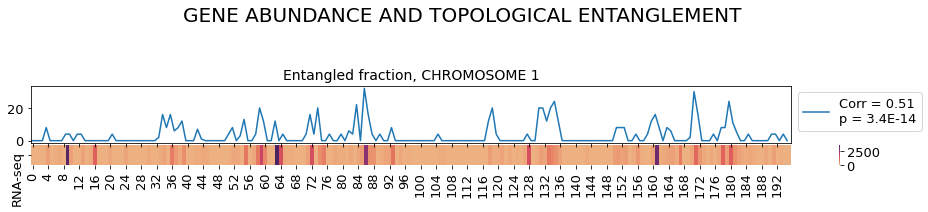

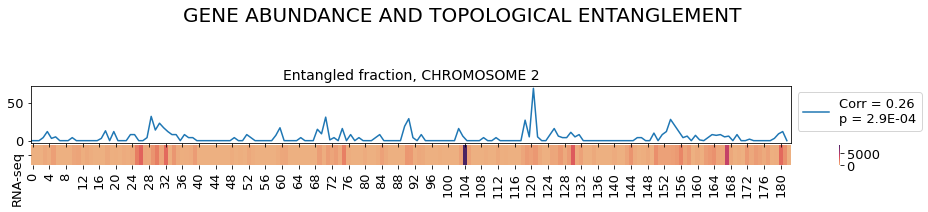

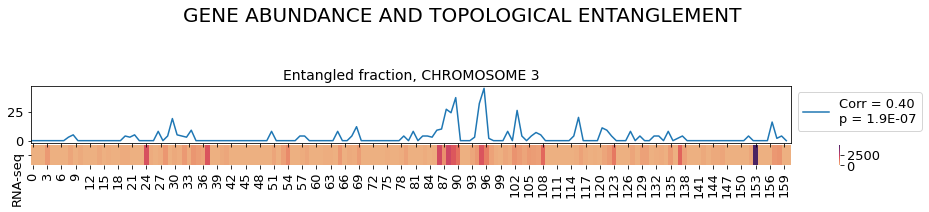

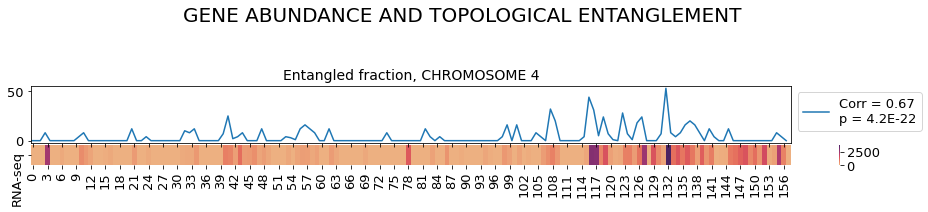

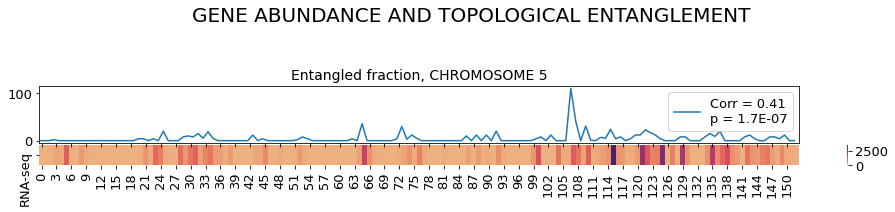

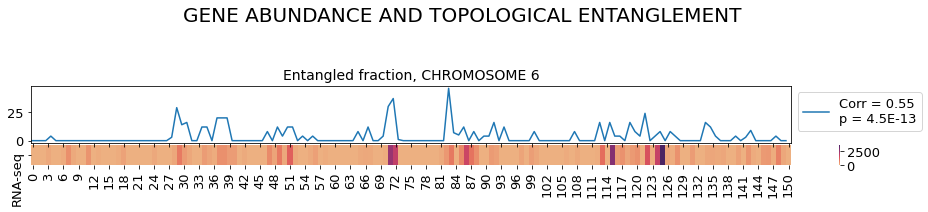

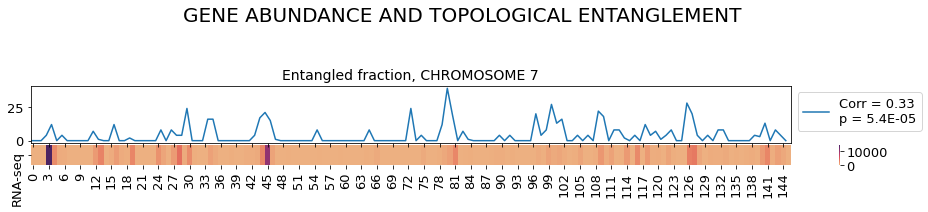

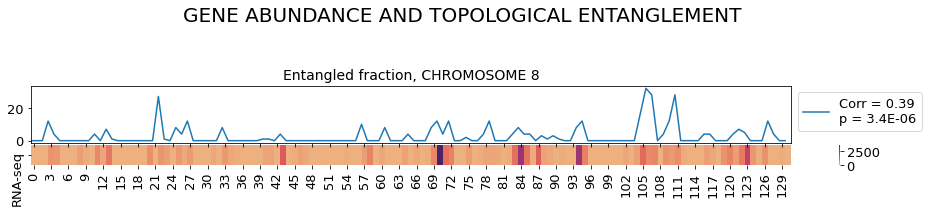

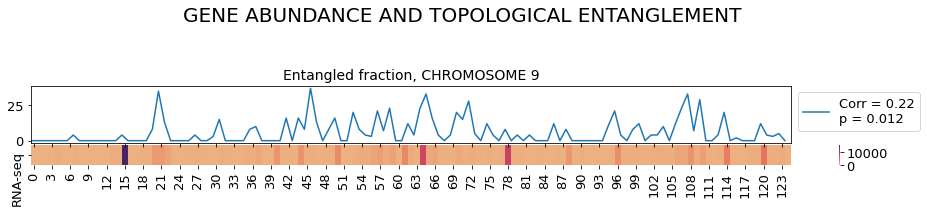

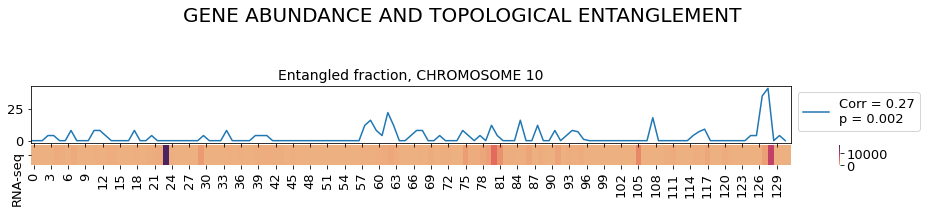

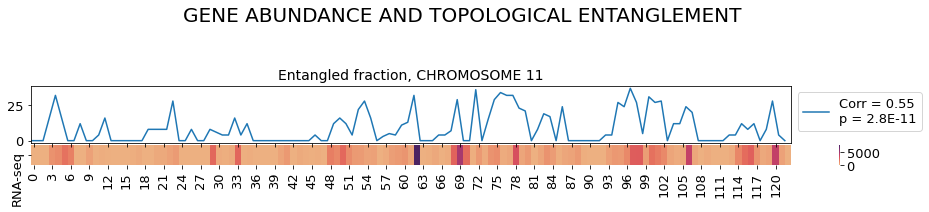

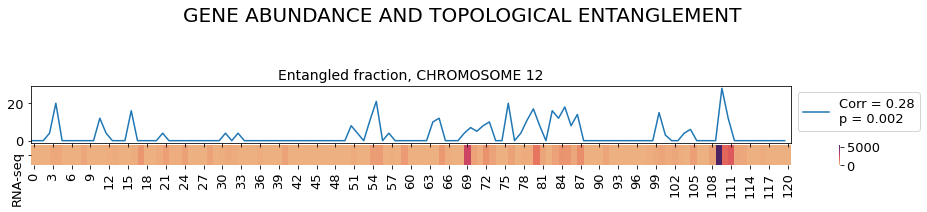

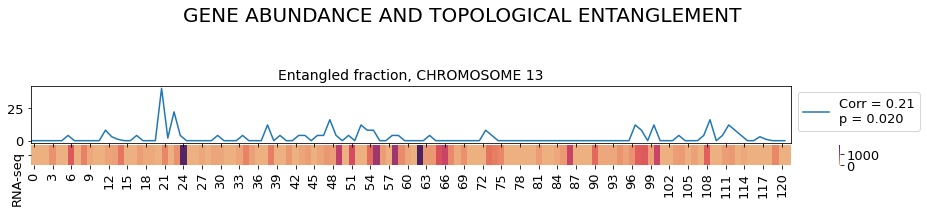

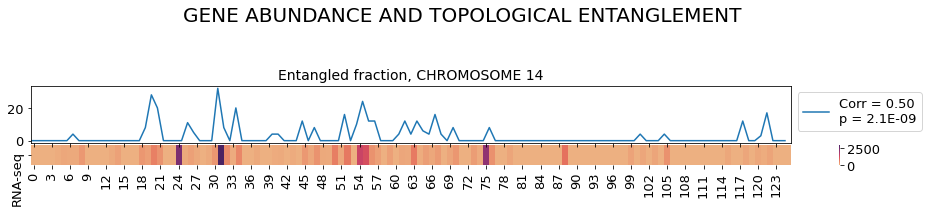

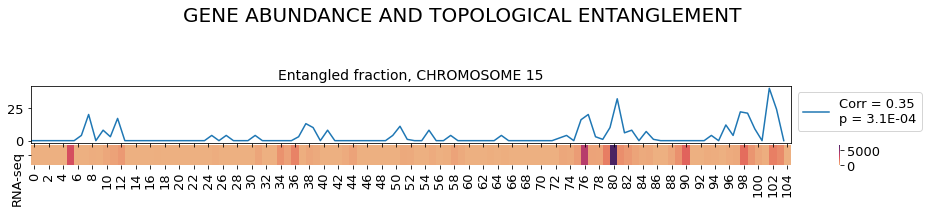

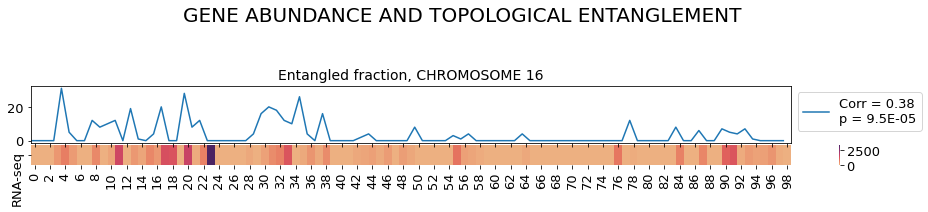

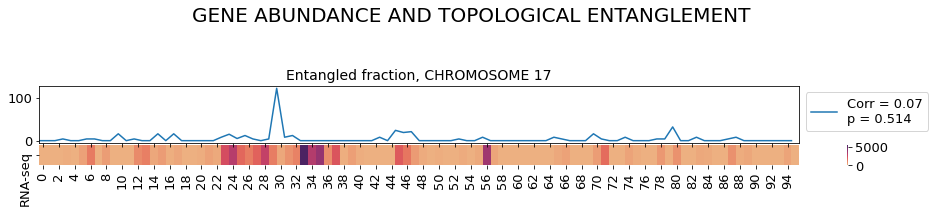

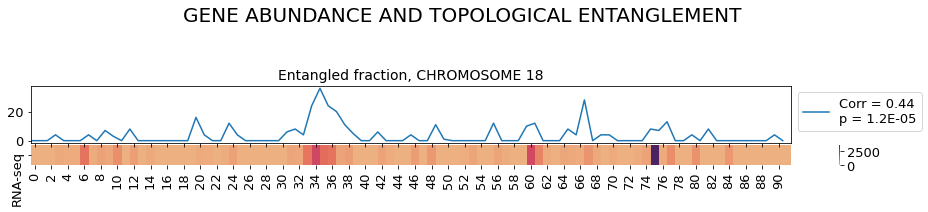

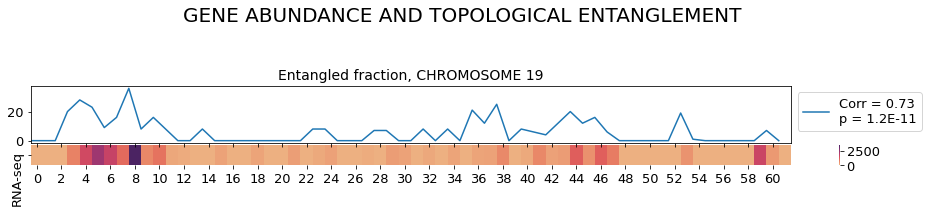

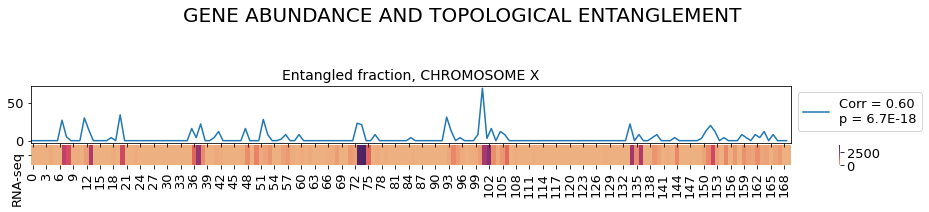

In [7]:
#Define variables to fill in the loop
correlation=np.zeros(n_all_chr)
pvalues=np.zeros(n_all_chr)


for chr_n, chrom in enumerate(chr_vec):
    
    #Load gene abundance data
    abundance = pd.read_csv('rna data/binned abundance/{}/'\
                            'abundance_{}.csv'.format(resolution_string, chrom))
    bins= abundance['Bins']
    abundance_high= np.copy(abundance['Abundance'])

    #filter for high abundance
    abundance_high[abundance_high< thresh_abundance]=0
    abundance['Highly expressed']= abundance_high
    
    #Filter likely single chromosome contacts
    contacts_chr= contacts[(contacts['#chr_A']== chrom) & (contacts['chr_B']== chrom)]
    contacts_chr=MiddlePointLoci(contacts_chr)
    likely_contacts_chr=contacts_chr[contacts_chr['num_obs']>=likelihood_thresh]
    
    #Calculate topology
    index= np.array([likely_contacts_chr['index A'], likely_contacts_chr['index B']])
    index= np.transpose(index)
    mat, psc = get_matrix(index, chrom)
    mat = Select_entangled_fraction(mat)
    likely_contacts_chr['Matrix trace']= np.sum(mat, axis=1)
    
    #Map topology matrix trace to genome structure
    trace_structure = Map_Topology_to_Structure(likely_contacts_chr, bins,  
                                                mode = Mode_Binning_entangledTrace)
    
    #Calculate correlation between topology trace and RNA-seq data
    corr, pvalue = correlate(abundance['Highly expressed'],trace_structure)
    correlation[chr_n]=corr
    pvalues[chr_n]=pvalue
    print('Chromosome {}: corr= {}, p= {}'.format(chr_n, corr, pvalue))

    #Plot double graph: topology trace and RNA-seq data
    stats = [corr, pvalue]
    data = {'RNA-seq': abundance['Highly expressed']}
    data=pd.DataFrame(data)
    f= plot_rectangle(trace_structure, data, params, stats)
    plt.suptitle('GENE ABUNDANCE AND TOPOLOGICAL ENTANGLEMENT',y=0.65, x=0.6)
    plt.title('Entangled fraction, CHROMOSOME {}'.format(chrom[3:]))
    
    if savefig:
        name_fig='DoublePlot_{}'.format(chrom)
        save_figures(f,path_figures, name_fig, 
        method='{}_{}_{}'.format(likelihood_thresh,Mode_Binning_entangledTrace, thresh_abundance))

#Save correlation data
df = {'Chromosome': chrom, 'Correlation': correlation, 'Pvalue': pvalues}
df=pd.DataFrame(df)
#df.to_csv('results/correlation rna seq/{}/correlation_{}_{}_{}.csv'.format(
#resolution_string, likelihood_thresh, Mode_Binning_entangledTrace,thresh_abundance))